<a href="https://colab.research.google.com/github/alxogm/ICF2024_lya/blob/main/Lya_CF_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlation Function of the Lyman-$\alpha$ forest in  EDR

October 2023

Alma González (U. of Guanajuato)

This notebook has been tested in Colaboratory in October 2023.

### Table of Contents
* [Overview](#overview)
* [Installs, Imports and Downloads](#imports)
* [Accessing the Data](#data)
* [Auto-correlation](#autocorrelation)

<a class="anchor" id="overview"></a>
## Overview

This notebook demonstrates how to use the delta (flux fluctuations) files provided as Lyman-$\alpha$ catalog value added catalog, as part of the DESI Early Data Release. We will compute the auto-correlation function of the Lyman-$\alpha$ forest. Finally we will compare our results with those reported by the DESI collaboration in [Gordon et.al. 2023](https://arxiv.org/abs/2308.10950)

## Bug Reporting

If you identify any errors please talk to me (gonzalez.alma@ugto.mx) as this specific tutorial is not yet in the main desihub repository.

<a class="anchor" id="imports"></a>
## Installs, Imports and Downloads



In [15]:
!pip install sparclclient

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.8/113.8 kB 1.1 MB/s eta 0:00:00


In [1]:
!pip install picca

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.4/613.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.0/429.0 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.6 MB/s eta 0:00:00
  Created wheel for fitsio: filename=fitsio-1.2.4-cp310-cp310-linux_x86_64.whl size=817005 sha256=287ab9be26ac90f09501f3c6a3c25704b83bfe54278ec2a61c612af3e6d43aa4
  Stored in directory: /root/.cache/pip/wheels/2d/12/c1/30f33e4d5b539fce39f05630a55ef3643f29aaf4f7597a917c
Successfully built fitsio


In [2]:
from   google.colab import drive
import os
import sys
import subprocess
import bs4
import requests
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import picca
from picca.wedgize import wedge
import fitsio
from astropy.table import Table

In [16]:
from sparcl.client import SparclClient
client = SparclClient()

In [3]:
#Mount the Drive and define some useful paths
drivepath='/content/drive/'
drive.mount(drivepath, force_remount=True)
desiedr_path = drivepath + '/MyDrive/ICF2024/desi_edr/'
if not os.path.exists(desiedr_path):
  os.makedirs(desiedr_path)
desicode_path = desiedr_path+'/desicode'
if not os.path.exists(desicode_path):
  os.makedirs(desicode_path)
specprod = 'fuji'    # Internal name for the EDR
specprod_dir = desiedr_path+specprod
if not os.path.exists(specprod_dir):
  os.makedirs(specprod_dir)

lya_dir = specprod_dir+'/lya'
if not os.path.exists(lya_dir):
  os.makedirs(lya_dir)

Mounted at /content/drive/


In [4]:
#clone desicode.
#You have to do this only if you did not ran the EDR_AnalyzeZcat_colab.ipynb before, you could comment out these cells if that is the case.
os.chdir(desicode_path)
subprocess.run('git clone https://github.com/desihub/desitarget.git --depth=1', shell=True, check=True)
subprocess.run('git clone https://github.com/desihub/desispec.git --depth=1', shell=True, check=True)
subprocess.run('git clone https://github.com/desihub/desiutil.git --depth=1', shell=True, check=True)
subprocess.run('git clone https://github.com/desihub/desimodel.git --depth=1', shell=True, check=True)
subprocess.run('git clone https://github.com/desihub/speclite.git --depth=1', shell=True, check=True)

In [5]:
#This lines adds the code paths to the main path to look for the relevan libraries, so we don't have to actually install the code
sys.path.insert(1,desicode_path+"/desitarget/py/")
sys.path.insert(1,desicode_path+"/desiutil/py/")
sys.path.insert(1,desicode_path+"/desispec/py/")
sys.path.insert(1,desicode_path+"/desimodel/py/")
sys.path.insert(1,desicode_path+'/speclite/')
import desispec.io

In [6]:
#Create some necesary directories
if not os.path.exists(lya_dir):
  os.makedirs(lya_dir)

if not os.path.exists(lya_dir+'/Delta'):
  os.makedirs(lya_dir+'/Delta')

if not os.path.exists(lya_dir+'/Log'):
  os.makedirs(lya_dir+'/Log')

if not os.path.exists(lya_dir+'/Correlations'):
  os.makedirs(lya_dir+'/Correlations')

<a class="anchor" id="data"></a>
## Accessing the data
In this case the data is the Lyman-$\alpha$ catalog, or what we usually refers to as the "Deltas". These are a value added catalog of the DESI EDR, and all documentation can be found [here](https://data.desi.lbl.gov/doc/releases/edr/vac/lymanalpha/), and the relevant reference is [Cesar Ramirez-Perez et. al. 2023](https://arxiv.org/abs/2306.06312) ... For a very basic, but practical, introduction of how these deltas are computed see this [desihigh notebook](https://github.com/michaelJwilson/desihigh/blob/main/Lymanalphaforest_explorers.ipynb)

In [7]:
#Download the Delta Files
#you only need to do this the first time, so you can comment the following lines later if you prefer

url = "https://data.desi.lbl.gov/public/edr/vac/edr/lya/fuji/v0.3/Delta/"
r = requests.get(url)
data = bs4.BeautifulSoup(r.text, "html.parser")
for l in data.find_all("a")[1:]:
    r = requests.get(url + l["href"])
    local_delta=lya_dir+'/Delta/'+l["href"]
    if not os.path.exists(local_delta):
      tmp = urllib.request.urlretrieve(url + l["href"],local_delta)
      print ("Downloaded file "+local_delta)
    else: continue
print("All Delta files are on disk")

Downloaded file /content/drive//MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-1.fits.gz
Downloaded file /content/drive//MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-10.fits.gz
Downloaded file /content/drive//MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-112.fits.gz
Downloaded file /content/drive//MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-123.fits.gz
Downloaded file /content/drive//MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-140.fits.gz
Downloaded file /content/drive//MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-143.fits.gz
Downloaded file /content/drive//MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-15.fits.gz
Downloaded file /content/drive//MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-18.fits.gz
Downloaded file /content/drive//MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-19.fits.gz
Downloaded file /content/drive//MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-20.fits.gz
Downloaded file /content/drive//MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-21.fits.gz
Downloaded file /c

Lest explore the content of one of the delta files and the attributes file.

In [8]:
delta_1=fitsio.FITS("/content/drive/MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-1.fits.gz")
print(delta_1)


  file: /content/drive/MyDrive/ICF2024/desi_edr/fuji/lya/Delta/delta-1.fits.gz
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      IMAGE_HDU       LAMBDA
  2      BINARY_TBL      METADATA
  3      IMAGE_HDU       DELTA
  4      IMAGE_HDU       WEIGHT
  5      IMAGE_HDU       CONT


In [9]:
metadata=Table(delta_1["METADATA"][:])
tids=metadata["TARGETID"]
print(tids)

     TARGETID    
-----------------
39633561992563839
39633561996755338
39633561996756385
39633561174674576
39633565725493056
39633565725493798
39633565725493810
39633565725494060
39633560331617316
39633565729687020
              ...
39633565813571806
39633564404288907
39633561283725832
39633561287918151
39633565125708026
39633562898532095
39633562105808503
39633562105808646
39633564412675325
39633564412676038
Length = 315 rows


In [10]:
wavelength=delta_1["LAMBDA"][:]
deltas=delta_1["DELTA"][:,:]

In [19]:
#Lets look at the first spectra
spectra = client.retrieve_by_specid([39633561992563839,],include=['wavelength', 'flux', 'ivar', 'model', 'wave_sigma','spectype','redshift','targetid','exptime'])
spec = spectra.records

Before proceding to look at the Deltas, lets look at the full spectra. For this, first we need to locate the files where these are stored. So we need to locate them in the redshift catalog.

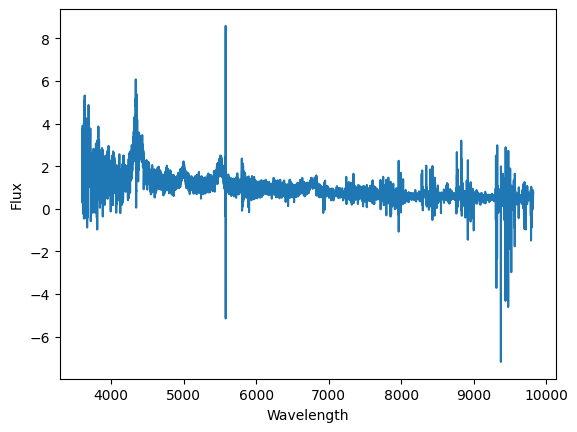

In [22]:
for _spec in spec:
  plt.plot(_spec.wavelength,_spec.flux)
  plt.xlabel("Wavelength")
  plt.ylabel("Flux")
  plt.show()

#Exercise:Add the redshift information and check all is consistent.

Now, lets see the deltas associated to these spectra

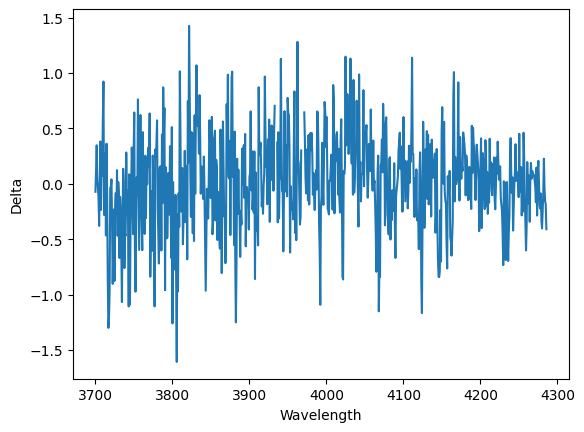

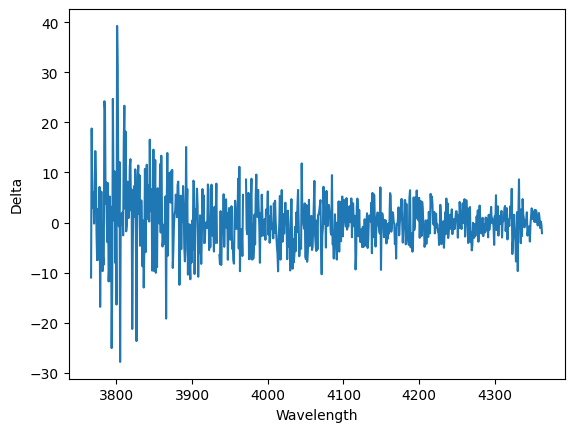

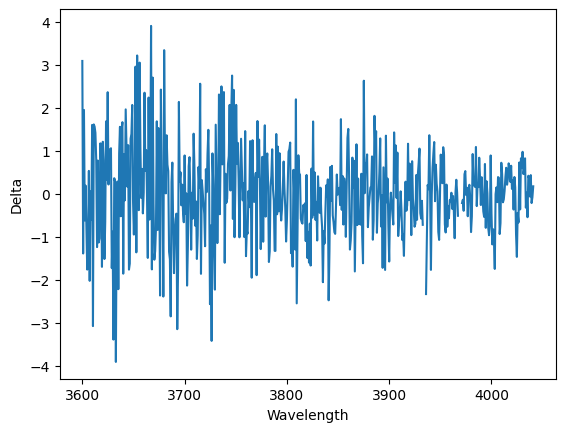

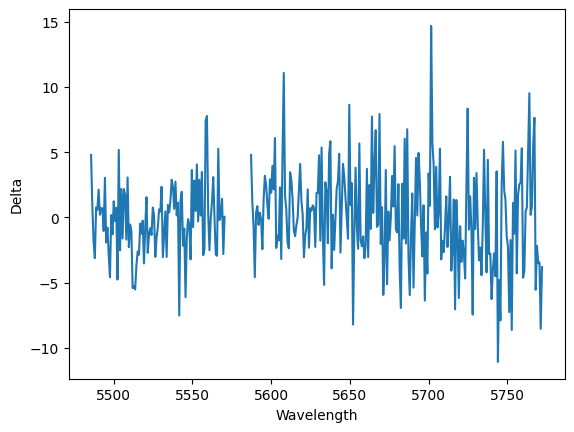

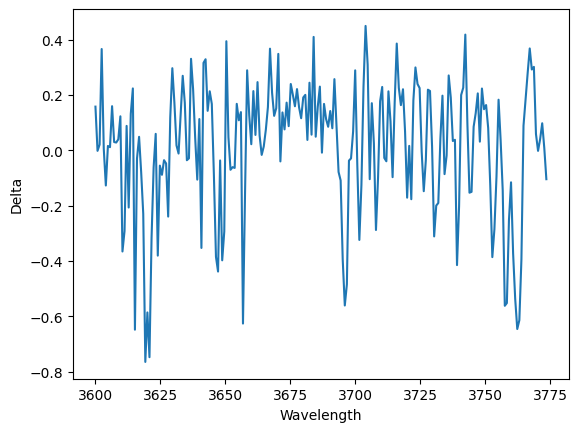

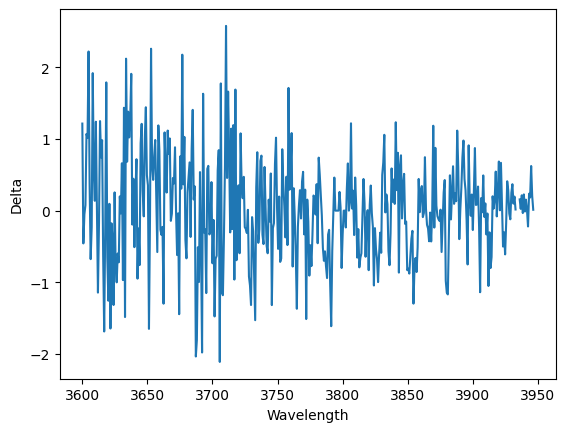

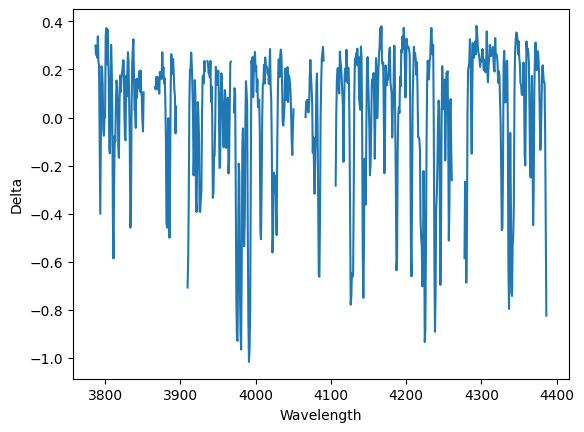

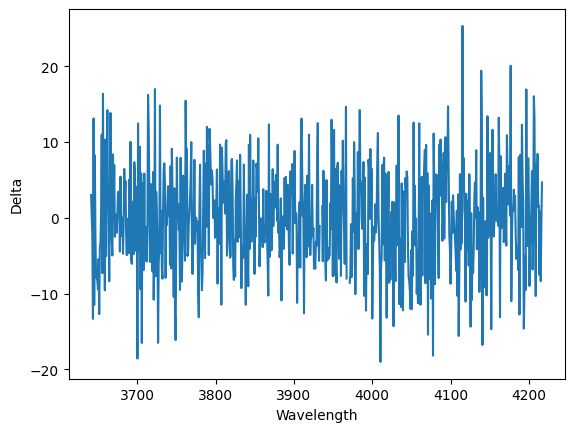

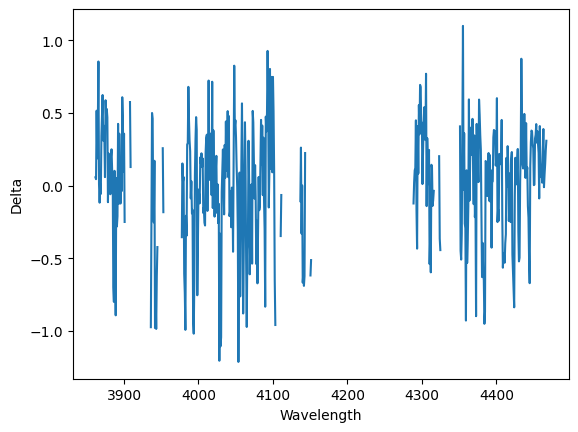

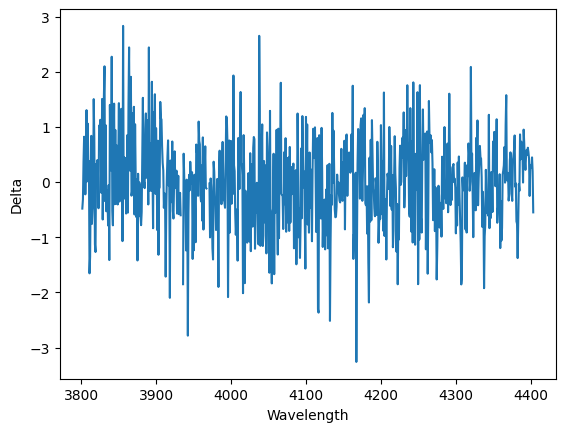

In [25]:
#Note thes in general will not be in the same order as above, we need to fix this...
for i in range(len(deltas[0:10])):
  plt.plot(wavelength,deltas[i])
  plt.xlabel("Wavelength")
  plt.ylabel("Delta")
  plt.show()

In [26]:
#Exercise: Make plots of the continuum and the weights.

<a class="anchor" id="autocorrelation"></a>
## Computing the auto-correlation function.

We will use the [picca](https://github.com/igmhub/picca/tree/master) code. The  main reference for what is this code doing is (Gordon et.al 2023)[https://arxiv.org/abs/2308.10950]

In [27]:
os.chdir(lya_dir+'/Correlations')
!pwd

/content/drive/MyDrive/ICF2024/desi_edr/fuji/lya/Correlations


In [28]:
#With this instruction we can compute the Lya auto correlation. We limited it to use only 1000 spectra, for speedness, but for using all the deltas available you can remove the --nspec 1000 flag
!picca_cf.py --out cf_lya_lya.fits.gz --in-dir /content/drive/MyDrive/Bucaramanga/desi_edr/fuji/lya/Delta/ --nspec 1000

ATTENTION: Analysis is not blinded!
Om=0.315, Or=0.0, wl=-1.0
z_min_sources 0.0



done, npix = 18
picca_cf.py - Time reading data: 0.990 minutes
computing xi: 0.0%
picca_cf.py - Time computing correlation function: 3.429 minutes
/usr/local/bin/picca_cf.py:413: DeprecationWarning: The keyword arguments '{'comment': ['R-parallel', 'R-transverse', 'Redshift', 'Number of pairs']}' are being ignored! This warning will be an error in a future version of `fitsio`!
  results.write(
/usr/local/bin/picca_cf.py:429: DeprecationWarning: The keyword arguments '{'comment': ['Healpix index', 'Sum of weight', 'Correlation']}' are being ignored! This warning will be an error in a future version of `fitsio`!
  results.write([healpix_list, weights_list, xi_list],
picca_cf.py - Time total : 4.421 minutes


In [29]:
#To compute the complete distortion Matrix but still do it in a reasonable time change the --nspec 1000 flag to --rej 0.99
!picca_dmat.py --out dmat.fits.gz --in-dir /content/drive/MyDrive/Bucaramanga/desi_edr/fuji/lya/Delta/ --nspec 1000

nproc 1
ATTENTION: Analysis is not blinded!
Om=0.315, Or=0.0, wl=-1.0



done, npix = 18
picca_dmat.py - Time reading data: 0.426 minutes
picca_dmat.py - Time computing distortion matrix: 0.000 minutes
computing xi: 0.0%
/usr/local/bin/picca_dmat.py:460: DeprecationWarning: The keyword arguments '{'comment': ['Sum of weight', 'Distortion matrix']}' are being ignored! This warning will be an error in a future version of `fitsio`!
  results.write([weights_dmat, dmat],
/usr/local/bin/picca_dmat.py:466: DeprecationWarning: The keyword arguments '{'comment': ['R-parallel', 'R-transverse', 'Redshift']}' are being ignored! This warning will be an error in a future version of `fitsio`!
  results.write([r_par, r_trans, z],
picca_dmat.py - Time total : 0.448 minutes


In [30]:
!picca_export.py --data cf_lya_lya.fits.gz --dmat dmat.fits.gz --out cf_lya_lya-exp.fits.gz

INFO: The covariance will be smoothed
Computing cov...
smoothing 2499

'none' correlations are not blinded.
/usr/local/bin/picca_export.py:334: DeprecationWarning: The keyword arguments '{'comment': ['R-parallel', 'R-transverse', 'Redshift', 'Correlation', 'Covariance matrix', 'Distortion matrix', 'Number of pairs']}' are being ignored! This warning will be an error in a future version of `fitsio`!
  results.write([xi, r_par, r_trans, z, covariance, dmat, num_pairs],
/usr/local/bin/picca_export.py:340: DeprecationWarning: The keyword arguments '{'comment': ['R-parallel model', 'R-transverse model', 'Redshift model']}' are being ignored! This warning will be an error in a future version of `fitsio`!
  results.write([r_par_dmat, r_trans_dmat, z_dmat],


In [31]:
#Lets check that all the produced files are in place
!ls

cf_lya_lya-exp.fits.gz	cf_lya_lya.fits.gz  dmat.fits.gz


In [36]:
if not os.path.exists("Fig4_auto_corr_wedge.npz"):
  !wget https://zenodo.org/records/8244702/files/Fig4_auto_corr_wedge.npz?download=1
  !wget https://zenodo.org/records/8244702/files/wedges.py?download=1
  !mv Fig4_auto_corr_wedge.npz?download=1 Fig4_auto_corr_wedge.npz
  !mv wedges.py?download=1 wedges.py
  print("Downloaded Fig4_auto_corr_wedge.npz")
  print("Downloaded wedges.py")
else:
  print("EDR CF files from Gordon 2023 are already on disk")

#Read the file with the EDR+M2 correlation function
Gordon2023=np.load("/content/drive/MyDrive/ICF2024/desi_edr/fuji/lya/Correlations/Fig4_auto_corr_wedge.npz")
from wedges import Wedge

EDR CF files from Gordon 2023 are already on disk


In [37]:
#Lets create a function that plot the results, and compares with eBOSS DR16 results.
def plot_cf(file_xis,xi_edr,rps=(-300,300,150), power=2,
                 mus=[1., 0.95, 0.8, 0.5, 0], figsize=(6, 7),
                 absMus=True, label=None,labels=None,colors=None):

    f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

    for k,file_xi in enumerate(file_xis):
        #- Read correlation function and covariance matrix
        h = fitsio.FITS(file_xi)
        try:
            da = h[1]['DA_BLIND'][:]
        except:
            da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        hh = h[1].read_header()
        rpmin = hh['RPMIN']
        rpmax = hh['RPMAX']
        rtmin = 0
        rtmax = hh['RTMAX']
        nrp = hh['NP']
        nrt = hh['NT']
        h.close()

        j=0

        for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
            b = picca.wedgize.wedge(mumin=mumin, mumax=mumax,
                                rpmin=rpmin, rpmax=rpmax,
                                rtmin=rtmin, rtmax=rtmax,
                                nrt=nrt, nrp=nrp, absoluteMu=absMus,
                                rmin=0., rmax=min(rpmax, rtmax),
                                nr=min(nrt, nrp))
            r,d,c = b.wedge(da,co)

            nrows = 2

                        #-- Wedges and best model
            y = d*r**power
            dy = np.sqrt(c.diagonal())*r**power



            ###
            b2 = Wedge(mu=(mumin,mumax),
              rp=rps,
              rt=(0,200,50),
              r=(0., 200., 50))

            xi=xi_edr['fugu_xi']
            cov=xi_edr['fugu_cov']

            r2,d2,c2=b2.__call__(xi,cov)
            c2 = np.sqrt(np.diagonal(c2))
            y2 = d2*r2**power
            dy2 =c2*r**power
            ####
            if absMus:
                if j==0:
                    axs[j//2][j%2].errorbar(
                    r, y, dy, fmt=".",label=labels[k],color=colors[k],alpha=0.7)
                    axs[j//2][j%2].errorbar(
                    r2, y2, dy2, fmt=".",label='Gordon et. al 2023',color='b',alpha=0.7)
                    axs[j//2][j%2].axvline(100)

                else:
                    axs[j//2][j%2].errorbar(
                        r, y, dy, fmt=".",color=colors[k],alpha=0.7)
                    axs[j//2][j%2].errorbar(
                        r2, y2, dy2, fmt=".",color='b',alpha=0.7)
                    axs[j//2][j%2].axvline(100)
            else:
                axs[j//2][j%2].errorbar(
                    r, y, dy, fmt="o")
                axs[j//2][j%2].errorbar(
                    r2, y2, dy2, fmt="o")

            axs[j//2][j%2].set_ylabel(r"$r^{power}\xi(r)$".format(power=power))
            if j//2==1:
                axs[j//2][j%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
            axs[j//2][j%2].legend(loc="best", fontsize=12)
            #axs[j//2][j%2].grid(True)
            j+=1
        axs[0][0].set_title(r"${}<\mu<{}$".format(0.95,1))
        axs[0][1].set_title(r"${}<\mu<{}$".format(0.8,0.95))
        axs[1][0].set_title(r"${}<\mu<{}$".format(0.5,8))
        axs[1][1].set_title(r"${}<\mu<{}$".format(0,0.5))

        plt.tight_layout()

    plt.show()

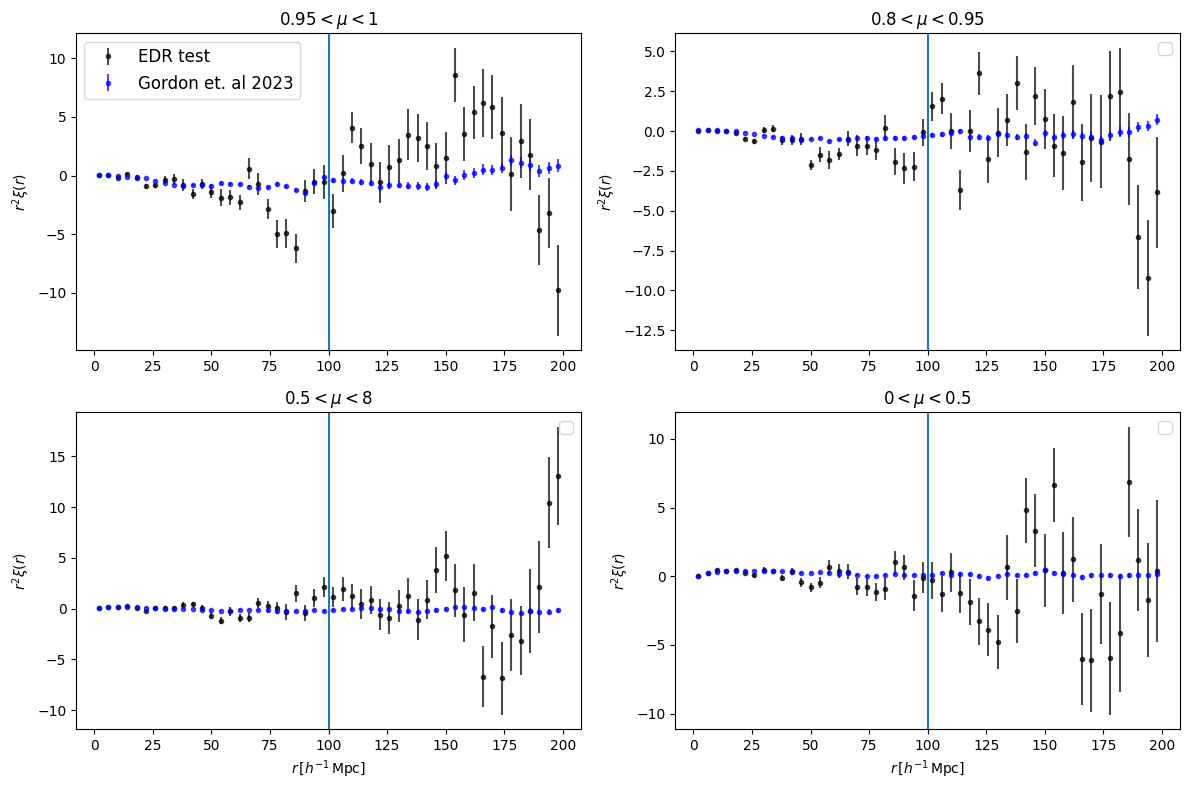

In [38]:
cf="cf_lya_lya-exp.fits.gz"

plot_cf([cf],Gordon2023,rps=(0,300,75), labels=["EDR test"],colors=['k'])

Try to compute the cross-correlation function. For this you will need the quasar catalog, you can try to derive it from the full catalog we have been working, but it would be better to use another VAC, the [BAL catalog](https://data.desi.lbl.gov/doc/releases/edr/vac/balqso/). This is very similar to actual catalog that was used in [Gordon et. al 2023](https://arxiv.org/abs/2308.10950).

The picca instructions to use are picca_xcf.py, picca_xdmat.py, and picca_export.py. You can see the required arguments by requesting --help